# Cargar el dataset Preprocesado

In [1]:
%pip install -q pandas
import pandas as pd

# Cargar el dataset desde la carpeta Data
processed_data = pd.read_csv('Data/youtoxic_english_1000_processed.csv')
processed_data.head()


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,aaannnyything,ability,able,absolutely,absolutely nothing,abuse,according,accountable,accountable actions,accounts,...,youre,youth,youtube,youve,zimmerman,zimmerman case,zimmerman michael,zimmermans,zionist,IsToxic
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.089395,0.093338,0.0,...,0.067337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,0.0,0.0,0.0,0.185577,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


# Preparar para el modelo de Machine Learning
Dividir el dataframe en 'features' y 'labels'.
Hacer subdivisiones en conjuntos de prueba y de entrenamiento. Escalar o normalizar las características si es necesario.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar la variable objetivo 'IsToxic' y nombrarla 'labels'
labels = processed_data['IsToxic']

# Eliminar la columna 'IsToxic' del dataframe y renombrar el dataframe como 'features'
features = processed_data.drop(columns=['IsToxic'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Iniciar StandardScaler
scaler = StandardScaler()

# Aplicar scaler a los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mostrar la forma de ambos sets
X_train_scaled.shape, X_test_scaled.shape

((800, 5000), (200, 5000))

# Primer modelo de ML
### Uso de un algoritmo de Regresión Logística


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Classification Report:
              precision    recall  f1-score   support

       False       0.62      0.73      0.67        93
        True       0.73      0.62      0.67       107

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.68      0.67      0.67       200



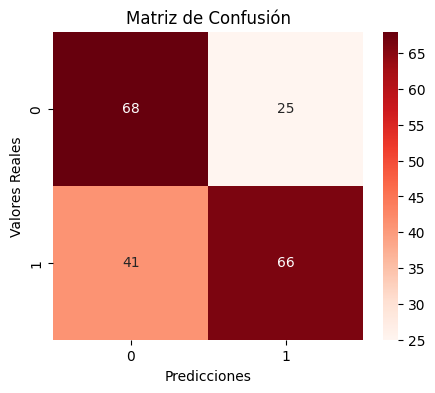


Accuracy en entrenamiento: 0.9962
Accuracy en test: 0.6700
Diferencia (overfitting): 0.3262


In [3]:
%pip install -q seaborn matplotlib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Crear y entrenar el modelo de regresión logística
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

# Imprimir métricas de rendimiento
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Crear y visualizar matriz de confusión
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Matriz de Confusión')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()

# Calcular y mostrar accuracy en train y test
train_score = lr_model.score(X_train_scaled, y_train)
test_score = lr_model.score(X_test_scaled, y_test)

print(f"\nAccuracy en entrenamiento: {train_score:.4f}")
print(f"Accuracy en test: {test_score:.4f}")
print(f"Diferencia (overfitting): {abs(train_score - test_score):.4f}")

### Optimización del modelo a través de un estudio elaborado con Optuna

In [ ]:
%pip install -q optuna

import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    # Definir espacio de hiperparámetros
    params = {
        'C': trial.suggest_float('C', 0.001, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }
    
    # Crear y entrenar modelo
    lr_optuna_model = LogisticRegression(**params, random_state=42)
    lr_optuna_model.fit(X_train_scaled, y_train)
    
    # Predecir y calcular accuracy
    y_pred = lr_optuna_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calcular penalización por overfitting
    train_score = lr_optuna_model.score(X_train_scaled, y_train)
    test_score = lr_optuna_model.score(X_test_scaled, y_test)
    overfitting_penalty = abs(train_score - test_score)
    
    # Objetivo: maximizar accuracy y minimizar overfitting
    return accuracy - (0.5 * overfitting_penalty)

# Crear estudio de optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Obtener mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros encontrados:")
print(best_params)

# Entrenar modelo final con mejores parámetros
final_optuna_model = LogisticRegression(**best_params, random_state=42)
final_optuna_model.fit(X_train_scaled, y_train)

# Evaluar modelo optimizado
train_score = final_optuna_model.score(X_train_scaled, y_train)
test_score = final_optuna_model.score(X_test_scaled, y_test)

print(f"\nAccuracy en entrenamiento: {train_score:.4f}")
print(f"Accuracy en test: {test_score:.4f}")
print(f"Diferencia (overfitting): {abs(train_score - test_score):.4f}")

# Visualizar proceso de optimización
optuna.visualization.plot_optimization_history(study)
plt.show()


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/aitor/Desktop/bootcamp IA Factoria F5/proyectos/youToxic_NLP_equipo14/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-14 13:26:19,285] A new study created in memory with name: no-name-968e3c1d-565a-4e6a-bf35-e30bf42d2706
[I 2024-11-14 13:26:19,540] Trial 0 finished with value: 0.5293749999999999 and parameters: {'C': 0.019821175936834745, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 702, 'class_weight': None}. Best is trial 0 with value: 0.5293749999999999.
[I 2024-11-14 13:26:19,837] Trial 1 finished with value: 0.536875 and parameters: {'C': 0.0015035540811053688, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 497, 'class_weight': None}. Best is trial 1 with value: 0.536875.
[I 2024-11-14 13:26:20,592] Trial 2 finished with value: 0.5518749999999999 and parameters: 

Mejores hiperparámetros encontrados:
{'C': 0.029248653254930337, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 1608, 'class_weight': 'balanced'}

Accuracy en entrenamiento: 0.7262
Accuracy en test: 0.6750
Diferencia (overfitting): 0.0512


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [4]:
print(study.best_params)

NameError: name 'study' is not defined

### Adoptar el modelo optimizado con los mejores hiperparámteros y medir su exactitud y sobreajuste

Optimized Model Classification Report:
              precision    recall  f1-score   support

       False       0.59      0.97      0.73        93
        True       0.94      0.42      0.58       107

    accuracy                           0.68       200
   macro avg       0.76      0.69      0.66       200
weighted avg       0.78      0.68      0.65       200



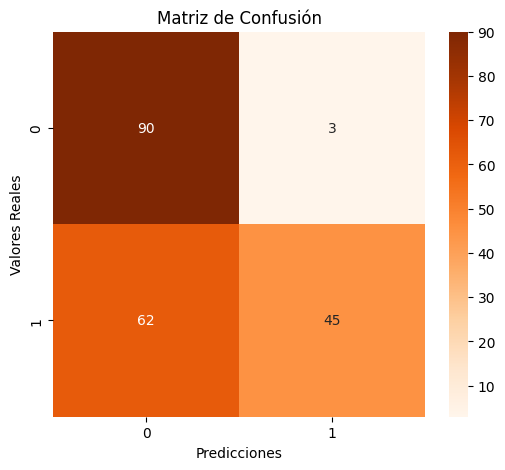


Accuracy en entrenamiento: 0.7262
Accuracy en test: 0.6750
Diferencia (overfitting): 0.0512


In [ ]:
final_optuna_model.fit(X_train_scaled, y_train)

y_pred = final_optuna_model.predict(X_test_scaled)

# Imprimir métricas de rendimiento
print("Optimized Model Classification Report:")
print(classification_report(y_test, y_pred))

# Crear y visualizar matriz de confusión
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión Modelo Optimizado')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()

# Calcular y mostrar accuracy en train y test
train_score = final_optuna_model.score(X_train_scaled, y_train)
test_score = final_optuna_model.score(X_test_scaled, y_test)

print(f"\nAccuracy en entrenamiento: {train_score:.4f}")
print(f"Accuracy en test: {test_score:.4f}")
print(f"Diferencia (overfitting): {abs(train_score - test_score):.4f}")

### Exportar el modelo optimizado usando Pickle

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Exportar el modelo
with open('toxic_text_classifier.pkl', 'wb') as model_file:
    pickle.dump(final_optuna_model, model_file)

# Definir y exportar el vectorizador (necesario para preprocesar nuevos datos)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)